# Vector store

In [47]:
#!pip uninstall -y -q gensim
!pip install -q gensim

In [48]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models import KeyedVectors
import heapq
from collections import defaultdict, namedtuple
import numpy as np # we mneed numpy 1.26.4
from numpy import float32 as FLOAT_TYPE



In [49]:
# 1. Parameters
VECTOR_SIZE = 500
WINDOW      = 5
MIN_COUNT   = 5
WORKERS     = 4
MAX_WORDS_IN_BATCH = 1000

### CustomLineSentence

In [50]:
import itertools
from gensim import utils

class CustomLineSentence:
    def __init__(self, source):
        self.source = source

    def __iter__(self):
        """Iterate through the lines in the source."""
        with utils.open(self.source, 'rb') as fin:
            for line in itertools.islice(fin, None):
                line = utils.to_unicode(line).split()
                # Convert all tokens to lowercase
                line = [word.lower() for word in line]
                i = 0
                while i < len(line):
                    yield line[i: i + MAX_WORDS_IN_BATCH]
                    i += MAX_WORDS_IN_BATCH


In [51]:
# 2. Load the text8 corpus as a stream of sentences
sentences = CustomLineSentence('data/Royal_data.txt')

print("Number of sentences:", len(list(sentences)))

Number of sentences: 14


In [52]:
print("Type of 'sentences':", type(sentences))
print("What we got from 'sentences':")
for i, s in enumerate(itertools.islice(sentences, 3)):
    print(f"Sentence {i+1}:", s)

    print("Length of sentence:", len(s))
    


Type of 'sentences': <class '__main__.CustomLineSentence'>
What we got from 'sentences':
Sentence 1: ['the', 'future', 'king', 'is', 'the', 'prince']
Length of sentence: 6
Sentence 2: ['daughter', 'is', 'the', 'princess']
Length of sentence: 4
Sentence 3: ['son', 'is', 'the', 'prince']
Length of sentence: 4


In [53]:
# limit to the first 100 sentences for downstream processing
sentences = list(sentences)[:100]
print("Number of sentences in subset:", len(sentences))

Number of sentences in subset: 14


# Custom word2vec class
by Creating bigrams

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import Counter

class BigramModel(nn.Module):
    def __init__(self, input_size, embed_size, output_size):
        super(BigramModel, self).__init__()
        self.fc1 = nn.Linear(input_size, embed_size)  # Embedding layer: projects one-hot input to dense vector
        self.fc2 = nn.Linear(embed_size, output_size) # Output layer: projects embedding to vocabulary size logits
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return torch.softmax(x, dim=1)  # Apply softmax to convert logits to probabilities over vocabulary

class CustomBigramWord2Vec:
    def __init__(self, documents=None, vector_size=100, window=5, min_count=5, epochs=500, workers=4, batch_size=256):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.epochs = epochs
        self.batch_size = batch_size
        self.workers = workers
        self.wv = {}
        self.index_to_key = []
        
        if documents is not None:
            self.build_vocab(documents)
            self.train_model()
    
    def build_vocab(self, documents):
        """Build vocabulary and create bigrams from documents"""
        # Flatten the list of documents into a list of words
        all_words = [word for doc in documents for word in doc]
        
        # Count word occurrences and filter by min_count
        word_counts = Counter(all_words)

        

        print("word_counts: ", word_counts)

        filtered_words = [word for word, count in word_counts.items() if count >= self.min_count]
        
        # Create word-to-index and index-to-word mappings
        self.index_to_key = sorted(filtered_words)

        print("index_to_key: ", self.index_to_key)

        self.word_to_idx = {word: i for i, word in enumerate(self.index_to_key)}
        self.vocab_size = len(self.index_to_key)

        print(f"word_to_idx: {self.word_to_idx}")
        
        print(f"Vocabulary size after filtering: {self.vocab_size}")
        
        print("documents: ", documents)

        # Create bigram pairs for training
        self.bigrams = []
        for doc in documents:
            filtered_doc = [word for word in doc if word in self.word_to_idx]
            print("filtered_doc: ", filtered_doc)
            for i in range(len(filtered_doc)):
                # Consider words within the window
                for j in range(max(0, i - self.window), min(len(filtered_doc), i + self.window + 1)):
                    if i != j:  # Skip the word itself
                        self.bigrams.append([filtered_doc[i], filtered_doc[j]])
        
        print(f"Created {len(self.bigrams)} bigram pairs for training")

        print("bigram samples: ", self.bigrams)
        
        # Create one-hot encoding dictionary
        self.onehot_dict = {}
        for i, word in enumerate(self.index_to_key):
            one_hot = torch.zeros(self.vocab_size)
            one_hot[i] = 1
            self.onehot_dict[word] = one_hot
            
        # Prepare training data
        self.X = []
        self.Y = []
        
        for bi in self.bigrams:
            if bi[0] in self.onehot_dict and bi[1] in self.onehot_dict:
                self.X.append(self.onehot_dict[bi[0]])
                self.Y.append(self.onehot_dict[bi[1]])
                
        self.X = torch.stack(self.X)
        self.Y_indices = torch.tensor([self.word_to_idx[bi[1]] for bi in self.bigrams 
                                      if bi[0] in self.onehot_dict and bi[1] in self.onehot_dict], 
                                     dtype=torch.long)

    def train_model(self):
        """Train the bigram model"""
        self.model = BigramModel(self.vocab_size, self.vector_size, self.vocab_size)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters())
        
        for epoch in range(self.epochs):
            permutation = torch.randperm(self.X.size()[0])
            epoch_loss = 0.0
            for i in range(0, self.X.size()[0], self.batch_size):
                indices = permutation[i:i+self.batch_size]
                batch_x, batch_y = self.X[indices], self.Y_indices[indices]
                optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            if (epoch+1) % 100 == 0:
                print(f"Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss:.4f}")
        
        # Extract word embeddings from the trained model
        weights = self.model.fc1.weight.data.T.numpy()  # shape: (vocab_size, vector_size)
        for i, word in enumerate(self.index_to_key):
            self.wv[word] = weights[i]

    def save(self, path):
        """Save model to disk"""
        data = {
            'wv': self.wv,
            'index_to_key': self.index_to_key,
            'vector_size': self.vector_size,
            'window': self.window,
            'min_count': self.min_count,
        }
        torch.save(data, path)
    
    @classmethod
    def load(cls, path):
        """Load model from disk"""
        data = torch.load(path)
        model = cls()
        model.wv = data['wv']
        model.index_to_key = data['index_to_key']
        model.vector_size = data['vector_size']
        model.window = data['window']
        model.min_count = data['min_count']
        return model
    

## Custom Doc2Vec Class
Use Gensim's Doc2Vec and TaggedDocument to build and use document vectors.

In [55]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pickle
import pickle

class CustomDoc2Vec:
    def __init__(self, documents, vector_size=100, window=5, min_count=5, epochs=5, workers=4, negative=5):
        self.vector_size = vector_size
        self.documents = documents
        self.doc_vectors = np.zeros((len(documents), vector_size), dtype=FLOAT_TYPE)
        
        # Train Word2Vec on the documents
        self.word_model = CustomBigramWord2Vec(
            documents=documents,
            vector_size=vector_size,
            window=window,
            min_count=min_count,
            workers=workers,
            epochs=epochs
        )
        
        # Generate document vectors by averaging word vectors
        for i, doc in enumerate(documents):
            valid_words = [word for word in doc if word in self.word_model.wv]
            if valid_words:
                self.doc_vectors[i] = np.mean([self.word_model.wv[word] for word in valid_words], axis=0)
    
    def infer_vector(self, document):
        """
        Infer a vector for a new document by averaging its word vectors
        """
        valid_words = [word for word in document if word in self.word_model.wv]
        if not valid_words:
            return np.zeros(self.vector_size, dtype=FLOAT_TYPE)
        return np.mean([self.word_model.wv[word] for word in valid_words], axis=0)
    
    def save(self, path):
        """Save model to file"""
        with open(path, 'wb') as f:
            pickle.dump({
                'word_model': self.word_model,
                'doc_vectors': self.doc_vectors,
                'vector_size': self.vector_size,
                'documents': self.documents
            }, f)
    
    @classmethod
    def load(cls, path):
        """Load model from file"""
        with open(path, 'rb') as f:
            data = pickle.load(f)
        
        obj = cls.__new__(cls)
        obj.word_model = data['word_model']
        obj.doc_vectors = data['doc_vectors']
        obj.vector_size = data['vector_size']
        obj.documents = data['documents']
        return obj

## Document Vector Store
Build document embeddings and search functionality

In [56]:
import numpy as np
from numpy.linalg import norm
from nltk.corpus import stopwords
import nltk


class DocumentVectorStore:
    def __init__(self, documents, embedding_model=None):
        """documents: list of token lists or raw text strings"""
        self.raw_documents = documents
        self.filter_stopwords = True


        # get stopwords rom nltk
        if self.filter_stopwords:
            try:
                self.stopwords = set(stopwords.words('english'))
            except:
                print("downloading stopwords...")
                nltk.download('stopwords')
                self.stopwords = set(stopwords.words('english'))


        # tokenize 
        self.tokenized_docs = [doc.split() if isinstance(doc, str) else doc for doc in documents]

        # If stopword filtering is enabled, process each document
        if self.filter_stopwords:
            processed = []  # initialize list to hold processed token lists
            for doc in self.raw_documents: 
                # split raw text into tokens if it's a string, otherwise use the list as is
                tokens = doc.split() if isinstance(doc, str) else doc
                # filter out tokens that are in the stopword set (case-insensitive)
                processed.append([tok for tok in tokens if tok.lower() not in self.stopwords])
                self.tokenized_docs = processed  # assign the filtered token lists
        
        self.model = embedding_model
        # build document embeddings
        self.build_doc_embeddings()

    def build_doc_embeddings(self):
        """Compute document embeddings by averaging word vectors"""
        embeddings = []
        print("model", self.model)
        for tokens in self.tokenized_docs:
            vecs = [self.model.wv[word] for word in tokens if word in self.model.wv]
            if vecs:
                doc_vec = np.mean(vecs, axis=0)
            else:
                doc_vec = np.zeros(self.model.vector_size)
            embeddings.append(doc_vec)
        self.doc_embeddings = np.vstack(embeddings)
    
    def search(self, query, topn=5):
        """Return topn most similar documents for a query (tokens or string)"""
        if isinstance(query, str):
            tokens = query.split()
        else:
            tokens = query
        
        # Filter stopwords if enabled
        if self.filter_stopwords:
            tokens = [word for word in tokens if word.lower() not in self.stopwords]

        # Define vecs before using it
        vecs = [self.model.wv[word] for word in tokens if word in self.model.wv]
        
        if vecs:
            q_vec = np.mean(vecs, axis=0)
        else:
            q_vec = np.zeros(self.model.vector_size)
            
        # cosine similarity
        sims = self.doc_embeddings.dot(q_vec) / (norm(self.doc_embeddings, axis=1) * norm(q_vec) + 1e-9)
        idx = np.argsort(-sims)[:topn]
        
        return [(i, float(sims[i])) for i in idx]


In [57]:
print("Number of documents:", len(sentences))

MIN_COUNT = 0

# Train our CustomDoc2Vec model
doc2vec_model = CustomDoc2Vec(
    documents=sentences,
    vector_size=VECTOR_SIZE,
    window=WINDOW,
    min_count=MIN_COUNT,
    epochs=1000,
    workers=WORKERS,
    negative=5
)

# Save and reload the Doc2Vec model
doc2vec_model.save('./models/custom_doc2vec.model')
loaded_doc2vec = CustomDoc2Vec.load('./models/custom_doc2vec.model')

# Build a DocumentVectorStore using the trained Doc2Vec embeddings
doc_store = DocumentVectorStore(sentences, embedding_model=loaded_doc2vec.word_model)

# testing search
query_doc = sentences[0]
results = doc_store.search(query_doc, topn=5)
print("Top 5 similar documents (index, similarity):", results)


Number of documents: 14
word_counts:  Counter({'the': 11, 'a': 10, 'is': 6, 'prince': 5, 'be': 5, 'king': 3, 'princess': 3, 'only': 3, 'man': 3, 'will': 3, 'can': 2, 'woman': 2, 'queen': 2, 'boy': 2, 'cat': 2, 'chased': 2, 'future': 1, 'daughter': 1, 'son': 1, 'strong': 1, 'beautiful': 1, 'now': 1, 'mouse': 1, 'dog': 1, 'dogs': 1, 'are': 1, 'loyal': 1, 'animals': 1})
index_to_key:  ['a', 'animals', 'are', 'be', 'beautiful', 'boy', 'can', 'cat', 'chased', 'daughter', 'dog', 'dogs', 'future', 'is', 'king', 'loyal', 'man', 'mouse', 'now', 'only', 'prince', 'princess', 'queen', 'son', 'strong', 'the', 'will', 'woman']
word_to_idx: {'a': 0, 'animals': 1, 'are': 2, 'be': 3, 'beautiful': 4, 'boy': 5, 'can': 6, 'cat': 7, 'chased': 8, 'daughter': 9, 'dog': 10, 'dogs': 11, 'future': 12, 'is': 13, 'king': 14, 'loyal': 15, 'man': 16, 'mouse': 17, 'now': 18, 'only': 19, 'prince': 20, 'princess': 21, 'queen': 22, 'son': 23, 'strong': 24, 'the': 25, 'will': 26, 'woman': 27}
Vocabulary size after filt

In [58]:
import textwrap

In [59]:
query_doc = sentences[1]
# join all words into one long string
text = " ".join(query_doc)

# wrap at 80 chars per line
print(textwrap.fill(text, width=80))

daughter is the princess


In [60]:
searchterm = """experience however in practice many autistic people have difficulty with working
in groups which impairs them even in the most technical of situations autistic
adults temple grandin one of the more successful adults with autism photograph
courtesy joshua nathaniel pritikin and william lawrence jarrold some autistic"""

In [61]:
sample_search_term = "king"

In [62]:
results = doc_store.search(sample_search_term, topn=20)
print(f"Top 5 similar documents for {sample_search_term}, (index, similarity):", results,)

Top 5 similar documents for king, (index, similarity): [(9, 0.5817898511886597), (3, 0.570260763168335), (0, 0.4491213262081146), (12, 0.14212770760059357), (11, 0.14116667211055756), (5, 0.08412794768810272), (4, -0.043271008878946304), (7, -0.04341568425297737), (10, -0.06725700199604034), (1, -0.0733218565583229), (2, -0.17197370529174805), (8, -0.17383943498134613), (6, -0.1853676587343216), (13, -0.20623809099197388)]


In [63]:
for idx, sim in results[:5]:
    print(f"Document {idx} (similarity: {sim:.4f}): {' '.join(sentences[idx])}")


Document 9 (similarity: 0.5818): prince will be king
Document 3 (similarity: 0.5703): only a man can be a king
Document 0 (similarity: 0.4491): the future king is the prince
Document 12 (similarity: 0.1421): the dog chased the cat
Document 11 (similarity: 0.1412): the cat chased the mouse


In [64]:
# join all words into one long string
query_doc = sentences[1]
text = " ".join(query_doc)

# wrap at 80 chars per line
print(textwrap.fill(text, width=80))

daughter is the princess


# We want to use PCA, WHY.

PCA (Principal Component Analysis) is used to reduce the dimensionality of high-dimensional data, such as embeddings, while preserving as much of the original information (variance) as possible.

We are going to give it `n_components=3` to reduce the embeddings to 3 dimensions.

In my test case, we just test the first 100 words.

Also, what I can see when I look at the data is that we have a lot of words that are stopwords. We are going to want to remove them.

(28, 500)


IndexError: list index out of range

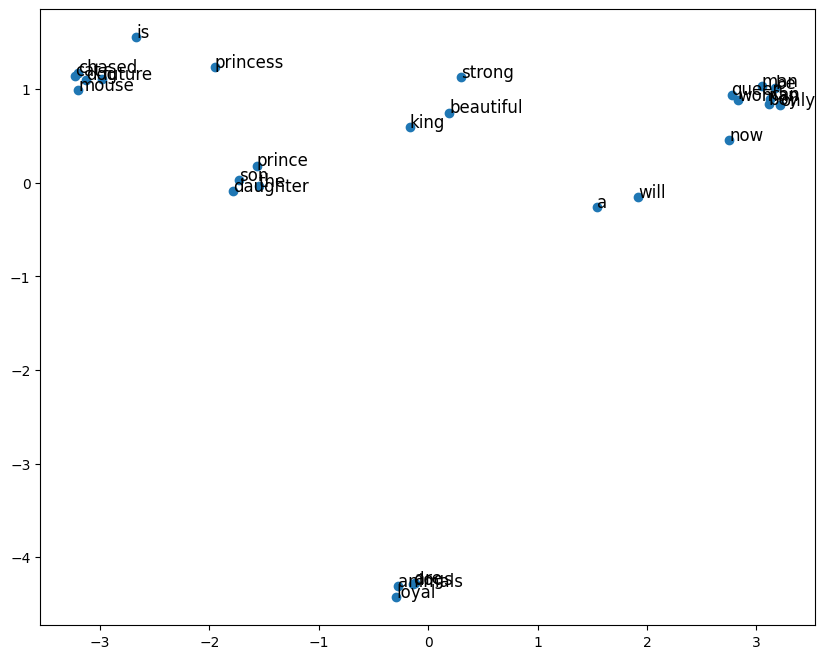

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

numOfWords = 28

# Extract word vectors from the model
words = doc2vec_model.word_model.index_to_key[:numOfWords]
word_vectors = [doc2vec_model.word_model.wv[word] for word in words]
weights = np.array(word_vectors)

print(weights.shape)  # (number of words, vector size)

# Reduce vectors to 2D
pca = PCA(n_components=2)
weights_2d = pca.fit_transform(weights)

# Plot the words in 2D
plt.figure(figsize=(10, 8))
plt.scatter(weights_2d[:, 0], weights_2d[:, 1])

# Annotate points with words
for i in range(numOfWords):
    plt.annotate(words[i], (weights_2d[i, 0], weights_2d[i, 1]), fontsize=12)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Word Embeddings in 2D')
plt.grid(True)
plt.tight_layout()
plt.show()


(30, 500)


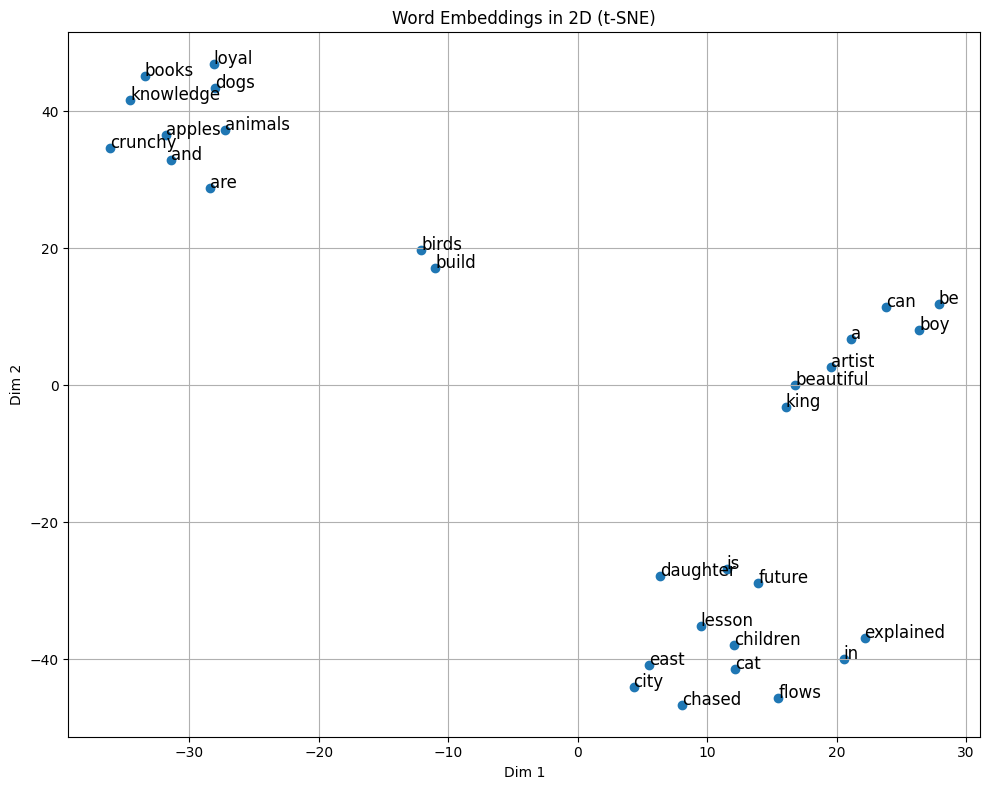

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

import matplotlib.pyplot as plt

numOfWords = 30

# Extract word vectors from the model
words = doc2vec_model.word_model.index_to_key[:numOfWords]
word_vectors = [doc2vec_model.word_model.wv[word] for word in words]
weights = np.array(word_vectors)

print(weights.shape)  # (number of words, vector size)

# Reduce vectors to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
weights_2d = tsne.fit_transform(weights)

# Plot the words in 2D
plt.figure(figsize=(10, 8))
plt.scatter(weights_2d[:, 0], weights_2d[:, 1])

# Annotate points with words
for i in range(numOfWords):
    plt.annotate(words[i], (weights_2d[i, 0], weights_2d[i, 1]), fontsize=12)

plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('Word Embeddings in 2D (t-SNE)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
sentences

[['the', 'future', 'king', 'is', 'the', 'prince'],
 ['daughter', 'is', 'the', 'princess'],
 ['son', 'is', 'the', 'prince'],
 ['only', 'a', 'man', 'can', 'be', 'a', 'king'],
 ['only', 'a', 'woman', 'can', 'be', 'a', 'queen'],
 ['the', 'princess', 'will', 'be', 'a', 'queen'],
 ['the', 'prince', 'is', 'a', 'strong', 'man'],
 ['the', 'princess', 'is', 'a', 'beautiful', 'woman'],
 ['prince', 'is', 'only', 'a', 'boy', 'now'],
 ['prince', 'will', 'be', 'king'],
 ['a', 'boy', 'will', 'be', 'a', 'man'],
 ['the', 'cat', 'chased', 'the', 'mouse'],
 ['dogs', 'are', 'loyal', 'animals'],
 ['the', 'sun', 'rises', 'in', 'the', 'east'],
 ['apples', 'are', 'sweet', 'and', 'crunchy'],
 ['the', 'teacher', 'explained', 'the', 'lesson'],
 ['books', 'are', 'sources', 'of', 'knowledge'],
 ['the', 'river', 'flows', 'through', 'the', 'city'],
 ['children', 'play', 'in', 'the', 'park'],
 ['the', 'artist', 'painted', 'a', 'beautiful', 'picture'],
 ['birds', 'build', 'nests', 'in', 'trees']]

# Evaluation of Vector Store Solution
